In [1]:
%matplotlib inline

In [2]:
import numpy as np
import kali.carma
import kali
import gatspy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]
from lsstlc import * # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Opsim minion_1016 & CARMA(1,0)

### Import MAF output

First, I will get minimum seperation between observations(not 15s exposures) within the same night from a record saved from MAF output. The npz file that stores the output from MAF has two entries, the first one named "pos_gap" contains the ra, dec and the minimum speration. The second entry, 'obsHist', is a breif metric record for each observation for that particular point (ra, dec) in the sky, e.g. ['expMJD', 'fiveSigmaDepth', 'fieldDec', 'fieldRA', 'filter', 'expDate', 'night'], which are all Opsim columns.

In [3]:
npz = np.load('/home/mount/obs_hist.npz') # load MAF output from file, which was saved from the obs_hist notebook
pos_gap = npz['pos_gap'] # [ra, dec, min_gap], min_gap in hours
obsHist = npz['obsHist'] # obsHist in structured array

In [4]:
# show MAF output with column names
print 'Minimum seperation between two observations within one night is {} days \n'.format(pos_gap[2])
print 'Observaton history shown below:'
print obsHist.dtype.names
print obsHist[0:10]

print '\nTotal number of observations: {}'.format(obsHist.shape[0])

Minimum seperation between two observations within one night is 0.0972000000766 days 

Observaton history shown below:
('expMJD', 'fiveSigmaDepth', 'fieldDec', 'fieldRA', 'filter', 'expDate', 'night')
[(59776.378633, 21.376139, 0.187126, 0.196871, u'z', 16967113, 196)
 (59776.400253, 21.547179, 0.187126, 0.196871, u'z', 16968981, 196)
 (59776.410504, 21.353368, 0.187126, 0.196871, u'z', 16969867, 196)
 (59776.440145, 21.241195, 0.187126, 0.196871, u'z', 16972428, 196)
 (59787.394998, 23.710949, 0.187126, 0.196871, u'g', 17918927, 207)
 (59787.424015, 20.694228, 0.187126, 0.196871, u'i', 17921434, 207)
 (59787.439703, 21.12525, 0.187126, 0.196871, u'z', 17922790, 207)
 (59788.301851, 23.610324, 0.187126, 0.196871, u'g', 17997279, 208)
 (59788.319809, 22.691322, 0.187126, 0.196871, u'i', 17998831, 208)
 (59788.340192999996, 22.851496, 0.187126, 0.196871, u'i', 18000592, 208)]

Total number of observations: 304


### Declare CARMA task

##### Available arguments for CARMATask
1. **nthreads: **number of hardware threads
2. **nburn: **Number of light curve steps to burn
3. **nwalker: **Number of MCMC walkers
4. **nsteps: **Number of MCMC steps 
5. **maxEvals: **Maximum number of evaluations when attempting to find starting location for MCMC
6. **xTol: **Fractional tolerance in optimized parameter value

In [5]:
# Initiate carma task
Task = kali.carma.CARMATask(2,1,nsteps = 500)

Next we need to determine coefficients and sampling rate for mock LC. Kali provides helper function to convert from timescales and light curve amplitude (i.e. the square root of the asymptotic autocorrelation function) to coefficients for the CARMA differential equation. In the example below, 107.8d and 43.2d are the decay timescales for the autocorrelation function of the CARMA(2,1) model, 5.5d is the MA timescale. The helper function requires three arguments, the CAR order, the MA order and an array containing the timescales and light curve amplitude. 

In [6]:
# declare input timescales and amplitude, organize in an array
r_1 = (-1.0/107.8) + 0j 
r_2 = (-1.0/43.2) + 0j
m_1 = (-1.0/5.5) + 0j
amp = 1.0
Rho = np.array([r_1, r_2, m_1, amp])

# use helper function to convert input to coefficients, and check whether valid
Theta = kali.carma.coeffs(2, 1, Rho) # use the array of roots above to solve for coefficients
print Theta # print out the calculated coefficients
print Task.check(Theta)

[ 0.03242459  0.00021473  0.00371959  0.02045774]
True


In the cell above, theta contains the final coefficients. Each entry in theta corresponds to $\alpha_1, \alpha_2, \beta_0, \beta_1$ in the CARMA(2,1) equation below accordingly.

$$d^2x + \alpha_1dx + \alpha_2x = \beta_0(dW) + \beta_1d^1(dW)$$

The parameters for the CARMA model can be set using the CARMATask.set() function. It takes three input, **dt** is the sampling rate for the mock LC, **theta** are the coefficients obtained above, **tnum** refers to the thread number that is hosting this model. Basically one CARMA task can host multiple models simutaneously, each with possibly different coefficients. Here, we only test with on model, and **tnum** is default to 0. We use the minimum seperation (min_gap) imported from MAF as our **dt**

### Simulate mock LC and add noise

In [7]:
dt = pos_gap[2]/24 # convert min_gap from hours to days, Kali uses days
Task.set(dt, Theta) # Will print 0 if parameters set successfuly

0

##### Noise-free

In [8]:
# simulate noise-free mock light curve with 10 years duration
LC = Task.simulate(duration=3650)

**Note**: dt and theta are not arguments for simulate. We have to set them seperately. Simulate will first determine whether the argument **tIn** is given, which can be used to generate irregularly sampled mock LC, if **tIn** is not provided, the cadence for mock LC will be determined using the duration given and **dt** set earlier.

###### Other arugments avaiable for simulate:  
- **tolIR**: Tolerance for irregularity, dafaults to 1e-3
- **fracIntrinsicVar**: Intrinsic variability fraction, defaults to 0.001  
- **fracNoiseToSignal**: Noise to signal fraction, defaults to 0.15  
- **maxSigma**: Maximum allowed sigma multiplier, defaults to 2.0  
- **minTimescale**: Minimum allowed timescale factor, defaults to 2.0  
- **maxTimescale**: Maximum allowed timescale factor, defaults to 0.5
- **tnum**: Thread index  

Also **burnSeed** and **distSeed**, which default to None

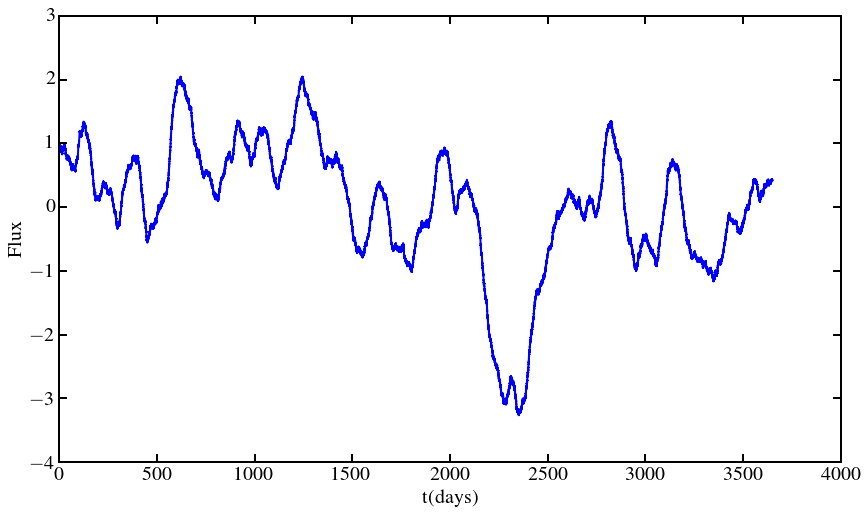

In [9]:
# plot simulated lightcurve
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.plot(LC.t, LC.x) # x is the variation about the mean flux

##### Add simulated noise

Kali adds noise based on input parameters **fracIntrisicVar** and **fracNoiseToSignal**. First, the absolute mean flux is obtained as absIntrinsicVar/fracIntrisicVar, absIntrinsicVar is the square root of the asymptotic autocorrelation function of the light curve or variability amplitude (according to Kali). We set this value to be 1.0 (amp)throught the root representation of the CARMA model coefficients. The absolute flux (absFlux)is then mean flux + the variation. For each data point on the light curve, the noise level is defined as absFlux$*$fracNoiseToSignal. The noise is a normally distributed random number with standard deviation equals to the noise level defined above and mean equals zero.     

In the case of added observation noise: 
- LC.y = absFlux + noise
- LC.yerr = noise level

In [10]:
# add noise with default fracNoiseToSignal = 0.001 and fracIntrinsicVar = 0.15
Task.observe(LC)

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f9b876c46d0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f9b876a3450>)

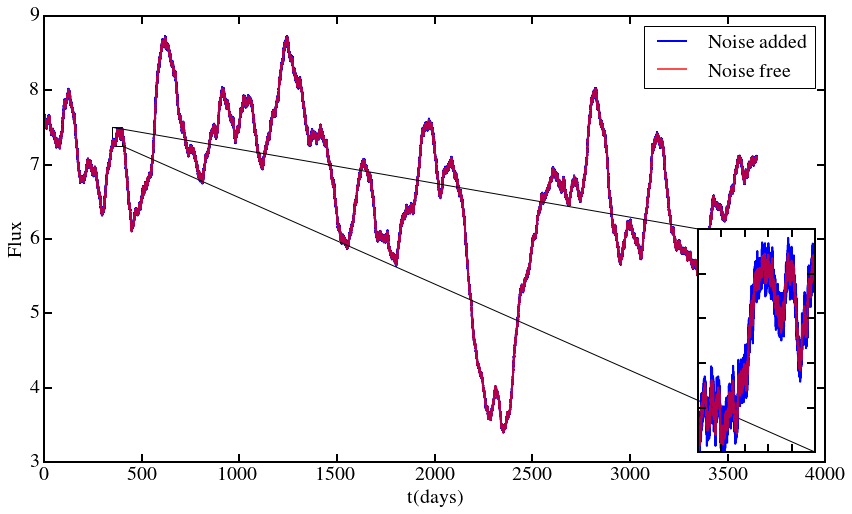

In [16]:
# plot both LC with and without added noise.
# np.mean(y) = np.mean(absMeanFlux + x + noise) = absMeanFlux + np.mean(x) + 0
# Therefore np.mean(y) - np.mean(x) = absMeanFlux
f2, ax2 = plt.subplots()
plt.ylabel('Flux')
plt.xlabel('t(days)')
ax2.plot(LC.t, LC.y, label='Noise added')
ax2.plot(LC.t, LC.x + np.mean(LC.y) - np.mean(LC.x), label='Noise free', color='r', alpha=0.7)
ax2.legend()

# add zoom-in figure
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax2, 12, loc=4)
axins.plot(LC.t, LC.y)
axins.plot(LC.t, LC.x + np.mean(LC.y) - np.mean(LC.x), color='r', alpha=0.7)
axins.set_xlim(350,400)
axins.set_ylim(7.25,7.5)
plt.yticks(visible=False)
plt.xticks(visible=False)

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax2, axins, loc1=2, loc2=4, fc="none", ec="0.01")